# Trabajo Final - Macroeconomía con Python
## Alumno: Alexander Max Tello Fuentes
## Código: 20156122

## Pregunta 3

In [2]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [3]:
!pip install pandas-datareader
import pandas_datareader.data as web
import datetime as dt

In [6]:
from statsmodels.tsa.api import VAR
from pandas.plotting import register_matplotlib_converters
pd.plotting.register_matplotlib_converters()

Extraemos la data de la FRED y la tratamos: pasamos de su forma nominal a su forma real.

a) Construimos la base de datos

In [7]:
start = dt.datetime(1960,1,1)
end   = dt.datetime(2019,12,31)
GT  = web.DataReader('W068RCQ027SBEA', 'fred', start=start, end=end)#Government Total Expenditures Nominal
IF  = web.DataReader('W054RC1Q027SBEA', 'fred', start=start, end=end)#Ingresos Fiscales Nominales
DEF  = web.DataReader('GDPDEF', 'fred', start=start, end=end)#Deflactor del PBI 2012=100
#Aqui debo deflactar el GT y log linealizar las variables
GTR=pd.DataFrame(np.log(GT.values/DEF.values))
IFR=pd.DataFrame(np.log(IF.values/DEF.values))
GDP   = web.DataReader('GDPC1', 'fred', start=start, end=end) #PBI Real
RGDP = np.log(GDP)
IFR.index=GT.index.shift(3, freq='M')
RGDP.index=GT.index.shift(3, freq='M')
GTR.index=GT.index.shift(3, freq='M')
#y=[IFTR,RGT,RGDP]'
d = pd.concat([ IFR, GTR, RGDP],axis=1)
d.columns =   ['ING','GAST','PBI']
print(d.head())
print(d.shape)

                 ING      GAST       PBI
DATE                                    
1960-03-31  1.921450  2.164078  8.094304
1960-06-30  1.913227  2.183441  8.088896
1960-09-30  1.909936  2.200380  8.093777
1960-12-31  1.900751  2.219276  8.080859
1961-03-31  1.902304  2.239464  8.087587
(240, 3)


Text(0.5, 1.0, 'Ratio gasto al PBI')

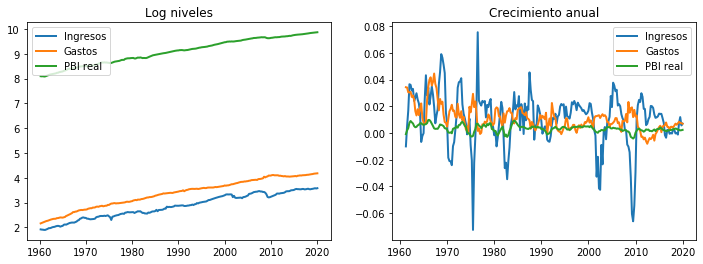

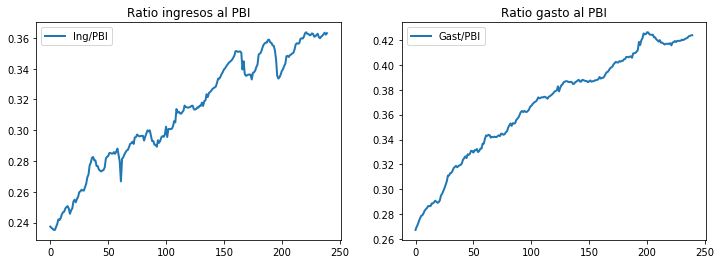

In [8]:
ci=np.log(IFR/IFR.shift(4))
cg=np.log(GTR/GTR.shift(4))
cb=np.log(RGDP/RGDP.shift(4))

IP=IFR.values/RGDP.values


fig, (ax11, ax12) = plt.subplots(ncols=2,figsize=(12, 4))
ax11.plot(d['ING'], linewidth=2,label='Ingresos')
ax11.plot(d['GAST'], linewidth=2,label='Gastos')
ax11.plot(d['PBI'], linewidth=2,label='PBI real')
ax11.legend(loc='upper left')
ax11.set_title('Log niveles')

ax12.plot(ci, linewidth=2,label='Ingresos')
ax12.plot(cg, linewidth=2,label='Gastos')
ax12.plot(cb, linewidth=2,label='PBI real')
ax12.legend(loc='best')
ax12.set_title('Crecimiento anual')

fig, (ax21, ax22) = plt.subplots(ncols=2,figsize=(12, 4))

ax21.plot(IP, linewidth=2,label='Ing/PBI')
ax21.legend(loc='upper left')
ax21.set_title('Ratio ingresos al PBI')

ax22.plot(GTR.values/RGDP.values, linewidth=2,label='Gast/PBI')
ax22.legend(loc='upper left')
ax22.set_title('Ratio gasto al PBI')

In [9]:
DF=d.iloc[0:160]#Extraemos una submuestra de 1960T1 hasta 1999T4
print(DF)
model = VAR(DF)

                 ING      GAST       PBI
DATE                                    
1960-03-31  1.921450  2.164078  8.094304
1960-06-30  1.913227  2.183441  8.088896
1960-09-30  1.909936  2.200380  8.093777
1960-12-31  1.900751  2.219276  8.080859
1961-03-31  1.902304  2.239464  8.087587
...              ...       ...       ...
1998-12-31  3.242808  3.649643  9.416297
1999-03-31  3.252634  3.653653  9.425717
1999-06-30  3.261658  3.659758  9.433379
1999-09-30  3.278696  3.670723  9.446391
1999-12-31  3.297432  3.692927  9.463244

[160 rows x 3 columns]


In [10]:
max_lags = 5
model.select_order(max_lags).summary()

,AIC,BIC,FPE,HQIC
0,-14.70,-14.64,4.145e-07,-14.67
1,-26.39,-26.16*,3.451e-12,-26.30*
2,-26.45*,-26.04,3.253e-12*,-26.28
3,-26.45,-25.86,3.270e-12,-26.21
4,-26.41,-25.65,3.389e-12,-26.10
5,-26.34,-25.40,3.629e-12,-25.96


El criterio de akaike nos indica que el número de rezagos óptimos es 2.

c) Estimamos el VAR en forma reducida

In [11]:
info = 'aic'
results = model.fit(maxlags=max_lags, ic=info)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Aug, 2020
Time:                     15:58:35
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -26.0562
Nobs:                     158.000    HQIC:                  -26.2979
Log likelihood:           1439.02    FPE:                3.21544e-12
AIC:                     -26.4632    Det(Omega_mle):     2.82332e-12
--------------------------------------------------------------------
Results for equation ING
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -1.178486         0.532685           -2.212           0.027
L1.ING          0.639888         0.089152            7.177           0.000
L1.GAST        -0.337432         0.172861           -1.952           0.051
L1.PBI     

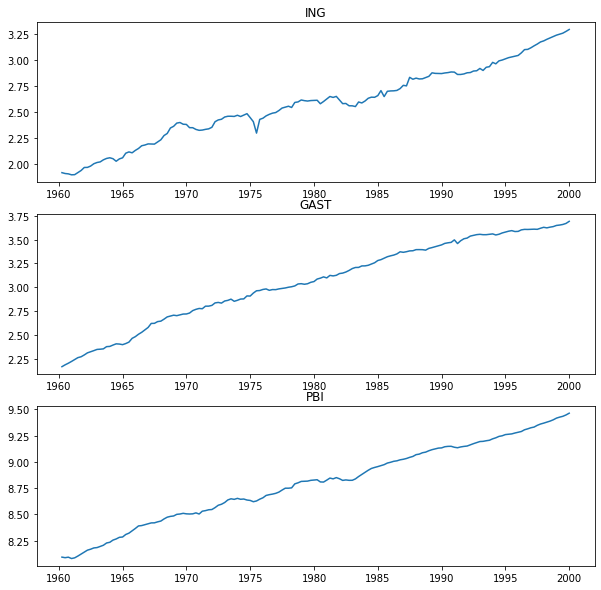

In [12]:
_ = results.plot()

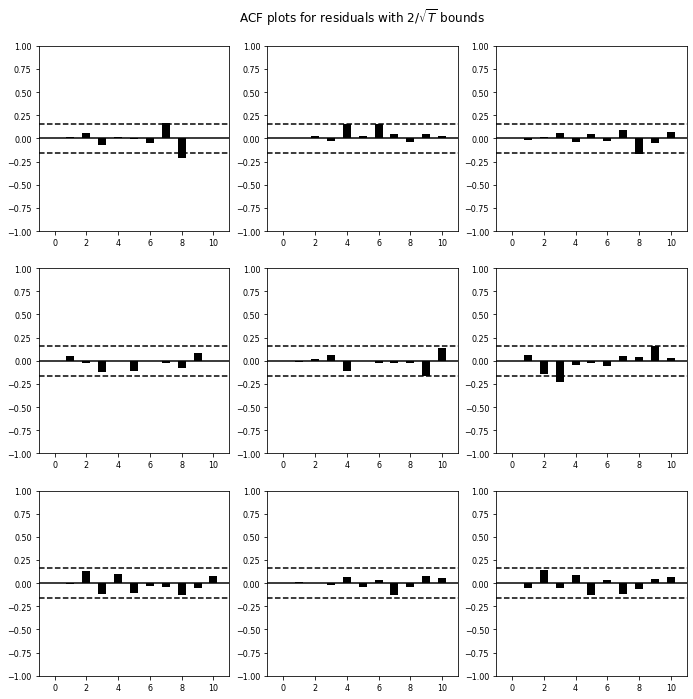

In [13]:
_ = results.plot_acorr()

d) Rolling forecast: to=1960q1 t1=1999q4

I)Proyectamos la recaudación tributaria hasta un año en adelante

In [14]:
fh = 4 # Horizonte del forecast hasta un año en adelante
nlag=2 #Número de rezagos obtenidos por el criterio de Akaike
fore = results.forecast(DF.values[-nlag:], fh)
fore

array([[3.301654  , 3.69706557, 9.46991737],
       [3.30693228, 3.70447738, 9.47556567],
       [3.31023055, 3.71148078, 9.48063701],
       [3.31378765, 3.71855447, 9.48558123]])

In [15]:
alpha = 0.05
fore_mid,fore_low,fore_up = results.forecast_interval(DF.values[-nlag:], fh,alpha=alpha)
print(fore_mid)

[[3.301654   3.69706557 9.46991737]
 [3.30693228 3.70447738 9.47556567]
 [3.31023055 3.71148078 9.48063701]
 [3.31378765 3.71855447 9.48558123]]


Para tener un mejor control del plot graficamos el forecasting para los ingresos fiscales de la siguiente manera:

Text(0.5, 1.0, 'Ingresos Tributarios')

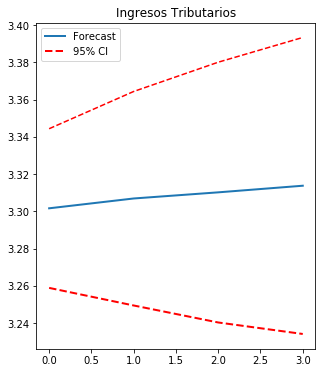

In [16]:
# ING,   GAST,  PBI
fig, (ax11) = plt.subplots(ncols=1,figsize=(5, 6))
ax11.plot(fore[:,0], linewidth=2,label='Forecast')
ax11.plot(fore_low[:,0], '--r', linewidth=2,label='95% CI')
ax11.plot(fore_up[:,0], '--r')
ax11.legend(loc='upper left')
ax11.set_title('Ingresos Tributarios')

HACEMOS EL ROLLING FORECASTING SEGÚN LOS PASOS ESPECIFICADOS

In [17]:
B=np.zeros((21,4))

In [18]:
fh = 4 # Horizonte del forecast hasta un año en adelante
nlag=2 #Número de rezagos obtenidos por el criterio de Akaike

for i in range(21):
    A=d.iloc[0+i:160+i]
    fore = results.forecast(A.values[-nlag:], fh)
    C = fore[:,0]-d.iloc[160+i:160+i+4,0].values#Diferenciamos las predicciones menos las realizaciones
    B[i,:]=C.T

print(B)
print(type(B))

[[-2.44198724e-02 -2.65378194e-02 -1.86798329e-02 -1.86853939e-02]
 [-8.84304934e-03 -1.60187284e-03 -3.85603969e-03 -2.49865441e-03]
 [ 1.41951843e-02  1.33539984e-02  1.54667453e-02  2.35368855e-02]
 [-4.61274007e-06  1.25717419e-03  9.97971849e-03  1.17633461e-01]
 [ 1.98575051e-03  1.10189081e-02  1.18832036e-01  7.01094728e-02]
 [-6.12708830e-04  1.06697766e-01  5.67101259e-02  1.35752061e-01]
 [ 1.07118320e-01  5.79373768e-02  1.37091865e-01  1.49058619e-01]
 [-1.69331533e-02  6.07011998e-02  8.20064806e-02  8.66716377e-02]
 [ 7.08073140e-02  9.21396896e-02  9.50579741e-02  9.93044238e-02]
 [ 4.63096810e-02  4.94111214e-02  6.05576001e-02  7.03456262e-02]
 [ 2.00182731e-02  3.08137151e-02  4.50919596e-02  5.83657079e-02]
 [ 1.65227732e-02  3.00771127e-02  4.49649168e-02  8.52229884e-02]
 [ 1.16064129e-02  2.57818596e-02  6.64756263e-02  3.72797796e-02]
 [ 1.72096811e-02  5.77601802e-02  2.95205554e-02  3.92607458e-02]
 [ 4.70818710e-02  1.88262590e-02  3.02910480e-02  3.24495977e

In [19]:
D = pd.DataFrame(data=B,index=list(range(1,22)), columns=["T1", "T2", "T3", "T4"])
print('-'*50)
print('D')
print(D)#Cada fila D+index representa las diferencias entre la predicción y lo que realmente ocurrió cada trimestre

--------------------------------------------------
D
          T1        T2        T3        T4
1  -0.024420 -0.026538 -0.018680 -0.018685
2  -0.008843 -0.001602 -0.003856 -0.002499
3   0.014195  0.013354  0.015467  0.023537
4  -0.000005  0.001257  0.009980  0.117633
5   0.001986  0.011019  0.118832  0.070109
6  -0.000613  0.106698  0.056710  0.135752
7   0.107118  0.057937  0.137092  0.149059
8  -0.016933  0.060701  0.082006  0.086672
9   0.070807  0.092140  0.095058  0.099304
10  0.046310  0.049411  0.060558  0.070346
11  0.020018  0.030814  0.045092  0.058366
12  0.016523  0.030077  0.044965  0.085223
13  0.011606  0.025782  0.066476  0.037280
14  0.017210  0.057760  0.029521  0.039261
15  0.047082  0.018826  0.030291  0.032450
16 -0.000525  0.011246  0.019485  0.012400
17  0.014797  0.022548  0.015730  0.014445
18  0.007782  0.000137 -0.000566 -0.050188
19 -0.000751 -0.001992 -0.050430 -0.040876
20 -0.000717 -0.049382 -0.039845 -0.036735
21 -0.045377 -0.036041 -0.032579 -0.041506


Ahora debemos calcular la raíz cuadrada del promedio de cuadrados de todas las diferencias.

In [20]:
D=D**2
print(D)

              T1            T2            T3        T4
1   5.963302e-04  7.042559e-04  3.489362e-04  0.000349
2   7.819952e-05  2.565997e-06  1.486904e-05  0.000006
3   2.015033e-04  1.783293e-04  2.392202e-04  0.000554
4   2.127737e-11  1.580487e-06  9.959478e-05  0.013838
5   3.943205e-06  1.214163e-04  1.412105e-02  0.004915
6   3.754121e-07  1.138441e-02  3.216038e-03  0.018429
7   1.147433e-02  3.356740e-03  1.879418e-02  0.022218
8   2.867317e-04  3.684636e-03  6.725063e-03  0.007512
9   5.013676e-03  8.489722e-03  9.036018e-03  0.009861
10  2.144587e-03  2.441459e-03  3.667223e-03  0.004949
11  4.007313e-04  9.494850e-04  2.033285e-03  0.003407
12  2.730020e-04  9.046327e-04  2.021844e-03  0.007263
13  1.347088e-04  6.647043e-04  4.419009e-03  0.001390
14  2.961731e-04  3.336238e-03  8.714632e-04  0.001541
15  2.216703e-03  3.544280e-04  9.175476e-04  0.001053
16  2.753439e-07  1.264747e-04  3.796671e-04  0.000154
17  2.189509e-04  5.084288e-04  2.474307e-04  0.000209
18  6.0562

Ahora debemos sumar los elementos de cada columna, luego dividirlo entre 21 y sacar la raíz cuadrada.

In [21]:
import math#Realizamos las operaciones
T1=math.sqrt((D['T1'].sum())/21)
T2=math.sqrt((D['T2'].sum())/21)
T3=math.sqrt((D['T3'].sum())/21)
T4=math.sqrt((D['T4'].sum())/21)
#Llevamos a un marco de datos de datos
RSMFE=np.zeros((1,4))
RSMFE[0,:] = [ T1, T2, T3, T4]
RSMFE = pd.DataFrame(data=RSMFE, columns=["T1", "T2", "T3", "T4"])
print('RSMFE')
print(RSMFE)

RSMFE
        T1        T2        T3       T4
0  0.03482  0.044159  0.058694  0.07068


¿Qué tan buena es la proyección de la recaudación fiscal?

La medida RSMFE es cercana a cero por lo que la proyección es buenaa, sin embargo, aumenta por cada trimestre que pasa por lo que cuanto más largo es el horizonte proyectado, más dificil es atinarle al valor correcto.

e) ¿Cómo responden las variables del modelo ante un incremento inesperado de impuestos? Utilizamos una identificación de Cholesky.

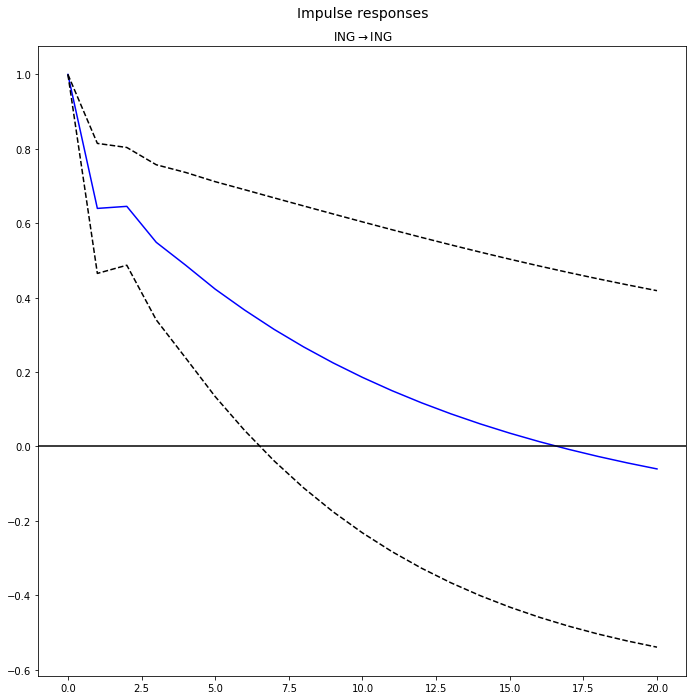

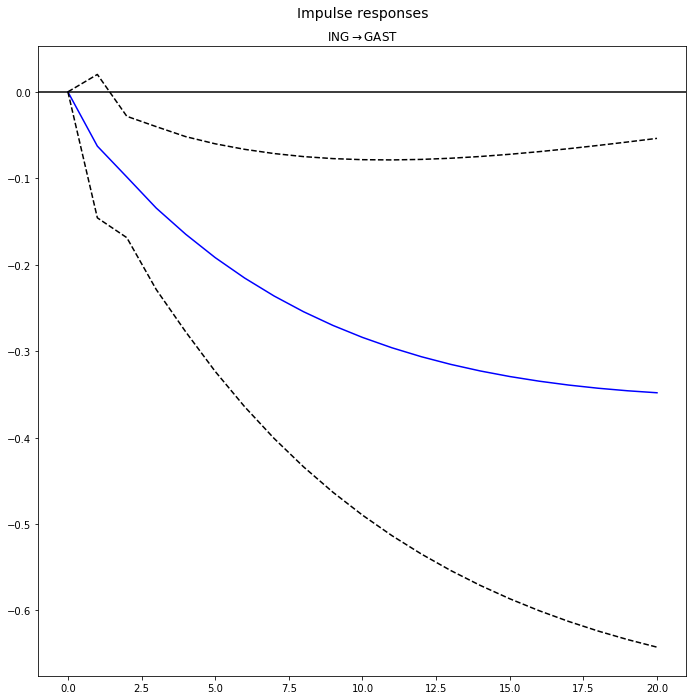

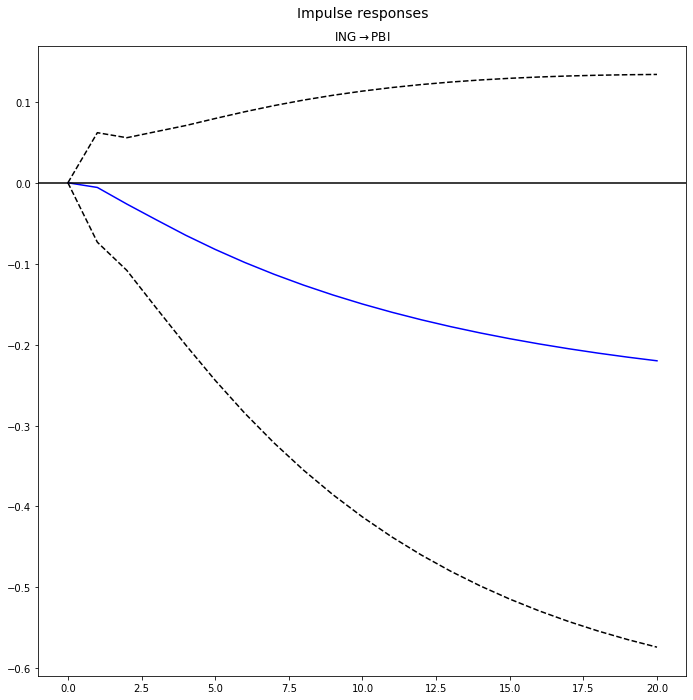

In [22]:
periods = 20
irf = results.irf(periods)#Por default utiliza la matriz de Choleski para identificar
_ = irf.plot(impulse='ING',response='ING')
_ = irf.plot(impulse='ING',response='GAST')
_ = irf.plot(impulse='ING',response='PBI')

f) Blanchard Perotti

In [23]:
from statsmodels.tsa.api import VAR, SVAR

Los autores argumentan que es razonable imponer las siguiente restricción: a23=b12=0

Esta restricción se interpreta en dos etapas: primero a23=0, se lee como que un choque reducido del PBI no afecta al gasto y se sustenta en que no es posible identificar ninguna retroalimentación automática entre la actividad económica y el gasto del gobierno. Segundo, b12=0 se lee como que un choque estructural de gasto no afecta a la recaudación tributaria, y responde a la pregunta ¿qué responde a qué? ¿El gasto responde a los impuestos o los impuestos responden al gasto? Al asumir que b12=0 se supone que el movimiento de los impuestos es primero por lo que un shock de gasto no podría mover los impuestos.

In [24]:
CC=pd.concat([ci, cg, cb],axis=1).dropna(axis=0)   #Dataframe en tasas de crecimiento
CC.columns = ['Ingresos', 'Gastos' ,'PBI']
CC.index = pd.DatetimeIndex(CC.index.values,freq=CC.index.inferred_freq)

CCM=CC.iloc[0:156] #Muestra en tasas de crecimiento

A = np.asarray([[1,0,'E'],
                [0,1,0],
                ['E','E',1]])
B = np.asarray([[1,0,0],
                ['E',1,0],
                [0,0,1]])
print(A)
print(B)

[['1' '0' 'E']
 ['0' '1' '0']
 ['E' 'E' '1']]
[['1' '0' '0']
 ['E' '1' '0']
 ['0' '0' '1']]


Para el VAR en niveles usamos la dataframe DF

In [25]:
modelAB = SVAR(DF, svar_type='AB', A=A, B=B)
resultsAB = modelAB.fit(maxlags=2,solver='ncg',maxiter=1000, maxfun=1000)
irfAB = resultsAB.irf(periods)

print('AB=')
print(resultsAB.A)
print(resultsAB.B)

AB=
[[  1.           0.         117.76432295]
 [  0.           1.           0.        ]
 [-46.30312643 -12.413825     1.        ]]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.04683794e-04 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


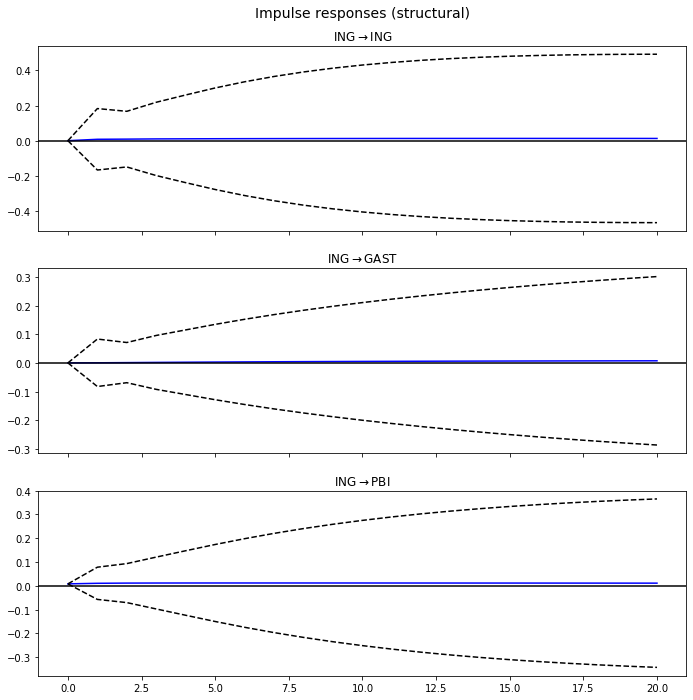

In [26]:
_ = irfAB.plot(impulse='ING')#,stderr_type='mc')
plt.savefig("IRF.jpg", bbox_inches='tight')

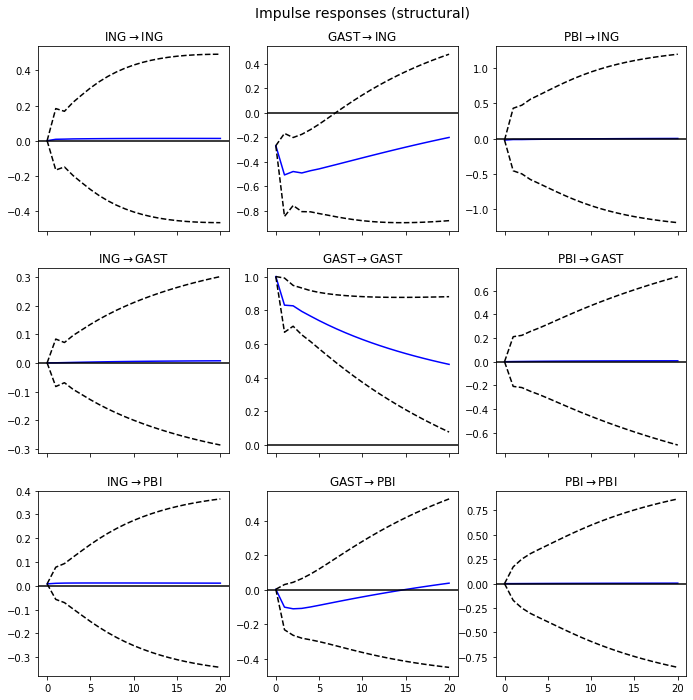

In [27]:
_ = irfAB.plot()

Para el dataframe en crecimiento anual usamos la data CCM.

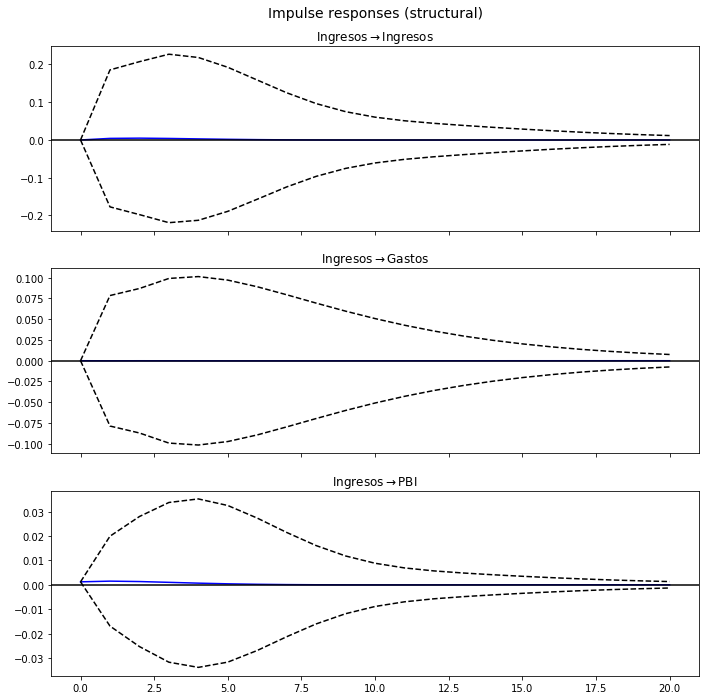

In [28]:
modelAB = SVAR(CCM, svar_type='AB', A=A, B=B)
resultsAB = modelAB.fit(maxlags=2,solver='ncg',maxiter=1000, maxfun=1000)
irfAB = resultsAB.irf(periods)
_ = irfAB.plot(impulse='Ingresos')#,stderr_type='mc')

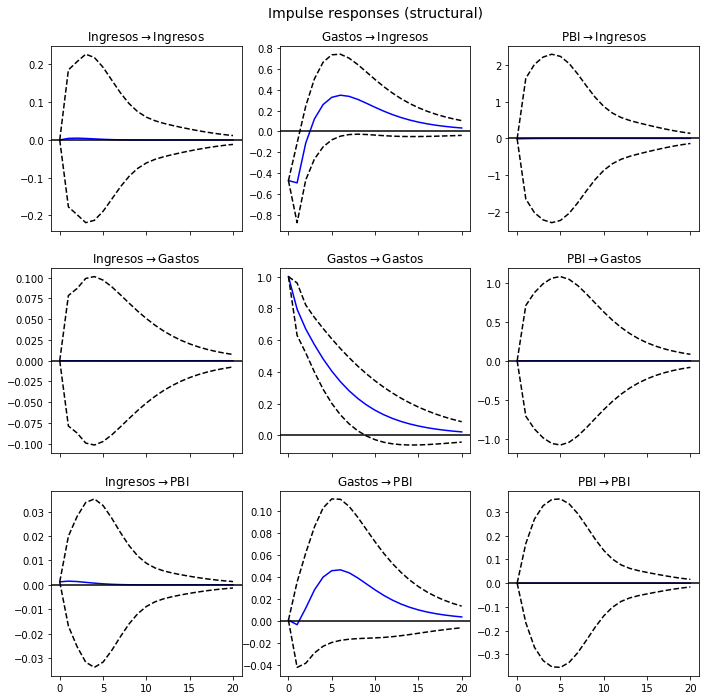

In [29]:
_ = irfAB.plot()

A comparación de Cholesky, la identificaión blanchard perotti indica que un shock de ingresos no afecta grandemente a ninguna de las tres variables. Sin embargo, se observa un ligero incremento en el PBI, aunque el resultado no es significativo. Esto podría deberse a la restricción impuesta.Blanchard y Perotti prueban con b21=0

In [30]:
B = np.asarray([[1,'E',0],
                [0,1,0],
                [0,0,1]])
print(B)

[['1' 'E' '0']
 ['0' '1' '0']
 ['0' '0' '1']]


In [31]:
model2AB = SVAR(DF, svar_type='AB', A=A, B=B)
results2AB = model2AB.fit(maxlags=2,solver='ncg',maxiter=1000, maxfun=1000)
irfAB = results2AB.irf(periods)

print('AB=')
print(results2AB.A)
print(results2AB.B)

AB=
[[  1.           0.         117.83040399]
 [  0.           1.           0.        ]
 [-46.30294309 -12.41369578   1.        ]]
[[1.         2.86264538 0.        ]
 [0.         1.         0.        ]
 [0.         0.         1.        ]]


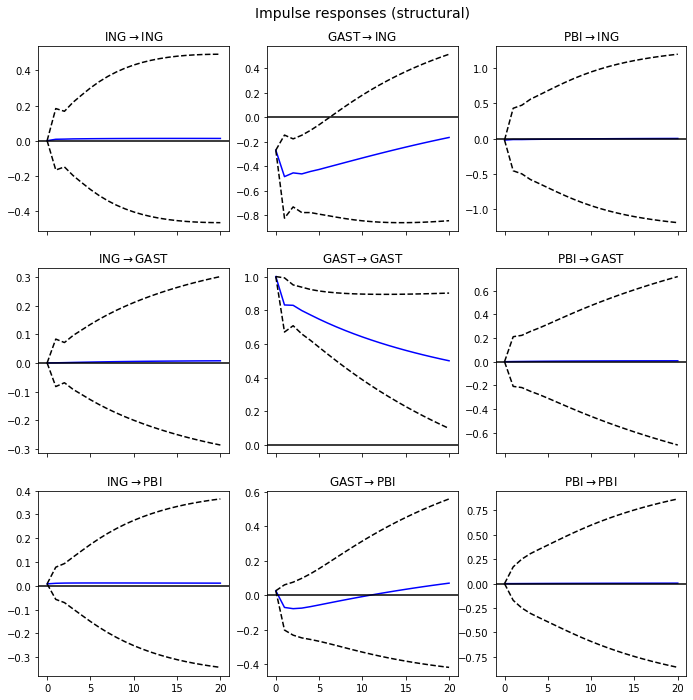

In [32]:
_ = irfAB.plot()

Aun así, los impulsos del ingreso a las otras variables siguen siendo pequeño y no significativos.